# SDWFS Cutout Footprints
## Author: Benjamin Floyd

Shows the positions of the SDWFS cutouts used as the background sample in the SPTcl-IRAGN study.

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import imshow_norm, ZScaleInterval, LinearStretch
from astropy.visualization.wcsaxes import Quadrangle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from astropy.table import Table
import astropy.units as u
import numpy as np
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

%matplotlib inline

In [2]:
# Read in the full SDWFS image that we will use as the backdrop
I1_SDWFS_img, I1_SDWFS_hdr = fits.getdata('Data_Repository/Images/Bootes/SDWFS/I1_bootes.v32.fits', header=True)
I1_SDWFS_wcs = WCS(I1_SDWFS_hdr)
I1_SDWFS_pixel_scale = I1_SDWFS_wcs.proj_plane_pixel_scales()[0]

In [3]:
# Read in the SDWFS-IRAGN catalog
sdwfs_iragn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')
sdwfs_iragn_grp = sdwfs_iragn.group_by('CUTOUT_ID')

# Get the mask WCSs
mask_wcss = [WCS(cutout['MASK_NAME'][0]) for cutout in sdwfs_iragn_grp.groups]

# Get the cutout centers
cutout_centers = {cutout['CUTOUT_ID'][0]: (cutout['SZ_RA'][0] * u.deg, cutout['SZ_DEC'][0] * u.deg) for cutout in sdwfs_iragn_grp.groups}
cutout_anchors = [np.array(I1_SDWFS_wcs.wcs_world2pix(cutout_center[0].value, cutout_center[1].value, 0)) - np.array(mask_wcs.pixel_shape) / 2 for cutout_center, mask_wcs in zip(cutout_centers.values(), mask_wcss)]

In [4]:
# Read in the ISCS cluster catalog
iscs_clusters = Table.read('Data_Repository/Catalogs/Bootes/ISCS/cluster.list.v10.Nsp1_official.clean_with_Zest.fits')

In [5]:
# Generate the quadrangles that are the cutout footprints
cutout_footprints = [Rectangle(cutout_anchor, width=mask_wcs.pixel_shape[0], height=mask_wcs.pixel_shape[1]) for mask_wcs, cutout_anchor in zip(mask_wcss, cutout_anchors)]

In [6]:
# Generate the cluster exclusion zones
exclusion_zones = []
for cluster in iscs_clusters:
    cluster_center = I1_SDWFS_wcs.wcs_world2pix(cluster['RA'], cluster['DEC'], 0)
    cluster_radius = 1 * u.Mpc * cosmo.arcsec_per_kpc_proper(cluster['z2']).to(I1_SDWFS_pixel_scale.unit / u.Mpc) / I1_SDWFS_pixel_scale
    exclusion_zones.append(Circle(cluster_center, radius=cluster_radius.value))

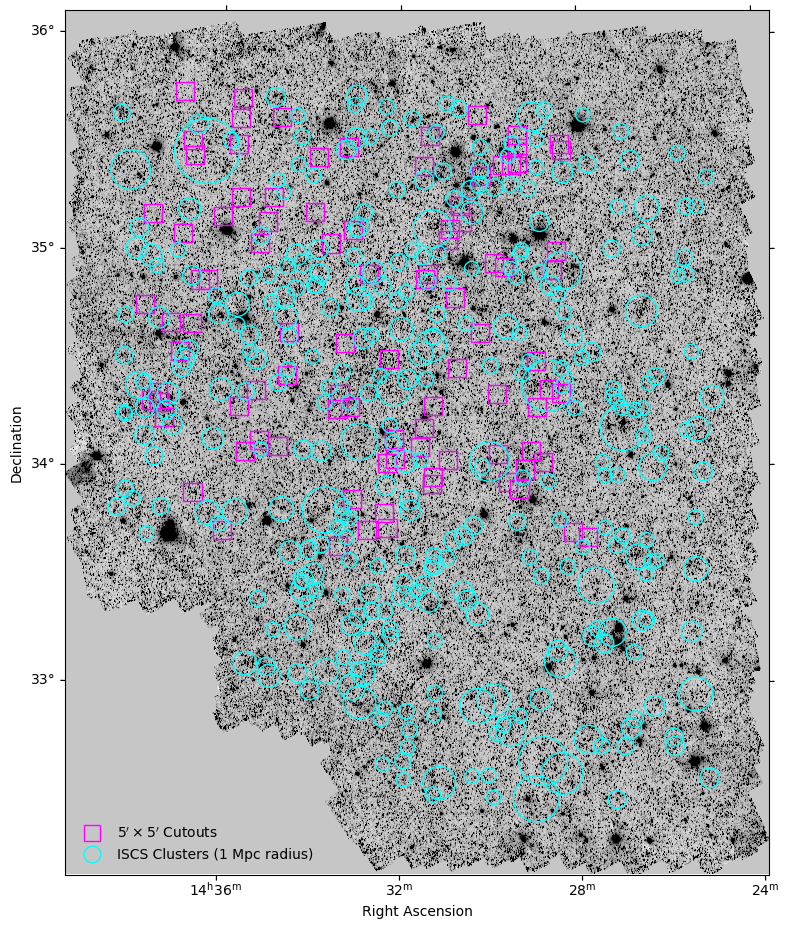

In [10]:
# Make the plot
fig, ax = plt.subplots(figsize=(8, 12), subplot_kw=dict(projection=I1_SDWFS_wcs))
imshow_norm(I1_SDWFS_img, origin='lower', stretch=LinearStretch(), interval=ZScaleInterval(), cmap='Greys', ax=ax)

# Add the cutout footprints and the cluster exclusion zones
ax.add_collection(PatchCollection(cutout_footprints, edgecolor='magenta', facecolor='none', lw=1))
ax.add_collection(PatchCollection(exclusion_zones, facecolor='none', edgecolor='cyan'))

legend_elements = [Line2D([0], [0], marker='s', markersize=12, color='none', markeredgecolor='magenta', markerfacecolor='none', label=r'$5^\prime\times5^\prime$ Cutouts'),
                   Line2D([0], [0], marker='o', markersize=12, color='none', markeredgecolor='cyan', markerfacecolor='none', label='ISCS Clusters (1 Mpc radius)')]
ax.legend(handles=legend_elements, loc='lower left', frameon=False)
ax.set(xlabel='Right Ascension', ylabel='Declination')
plt.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/Plots/SDWFS_cutout_footprint_with_ISCS.pdf', dpi=500)